<a href="https://colab.research.google.com/github/BirenderPanwar/EVA4_Phase1/blob/master/session11/EVA4S11_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objectives:
1. Custom Resnet architecture for CIFAR10
2. One Cycle Policy
3. Uses this transform -RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)
4. Batch size = 512
5. Uses One Cycle Policy such that:
- Total Epochs = 24
- Max at Epoch = 5
- LRMIN = FIND
- LRMAX = FIND



In [0]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Check for current directory and necessary files availability

In [0]:
# check current directory
!pwd

/content


In [0]:
# change to working directory
cd '/content/gdrive/My Drive/TSAI/EVA_Phase1/session11/s11_submission/'

/content/gdrive/My Drive/TSAI/EVA_Phase1/session11/s11_submission


In [0]:
# verify if all necessary files are avaiabale in current directory for loading
!ls

print("\nfiles under /models: ")
!ls ./models/

print("\nfiles under /utils: ")
!ls ./utils/

print("\nfiles under /gradcam: ")
!ls ./gradcam/

data		    EVA4S11_main_v1.ipynb  images  readme.md	 utils
EVA4S11_main.ipynb  gradcam		   models  saved_models

files under /models: 
cifar10_net_cnn.py  __pycache__  quiz_dnn.py  resnet_custom.py	resnet.py

files under /utils: 
albumentations_utils.py  lr_finder.py	   model_utils.py  regularization.py
common_utils.py		 lr_range_test.py  plot_utils.py
data_utils.py		 model_history.py  __pycache__

files under /gradcam: 
gradcam_abs.py	gradcam.py  gradcam_utils.py  __pycache__


# Load standard and custom python packages

In [0]:
# Load standard packages

from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import pkgutil
import importlib

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("apex module does not exist")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

from utils.lr_finder import LRFinder # cutom module for LR finder

In [0]:
import albumentations # to apply image augmentation using albumentations library.
print(albumentations.__version__) # check verison

# this is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install -U git+https://github.com/albu/albumentations # --no-cache-dir

0.4.5


In [0]:
# load custom python packages
import utils.common_utils as cutils          # common utililies fxn
import utils.model_utils as mutils           # utilities for basic conv block, depthwise seperable blocks, train, test, build fucntions
import utils.model_history as model_history  # utilitie for storing and visualizing model results
from utils.plot_utils import PlotUtils       # utilities for ploting images, model history, misclassified images etc
import models.cifar10_net_cnn as cifar10_net_cnn  # CIFAR10 network design using custom CNN network
import models.resnet as resnet                    # resnet model
from models.resnet_custom import EVAS11_ResNet    # custom resnet model for EVA session-11
from utils.lr_range_test import LRRangeTest       # module for finding Max LR

import utils.albumentations_utils as album_utils # utilities fxn based on albumentations
import gradcam.gradcam_abs as gradcamAbs         # abstraction for GradCam module

In [0]:
# to autoreload all the custom files when modified
import autoreload
%load_ext autoreload
%autoreload

# Check GPU avaiability
use cuda and get device with GPU

In [0]:
# check GPU availability and use cuda to get GPU device
cuda, device = cutils.get_device()

CUDA Available? True
Device:  cuda:0


# Basis configurations for CIFAR10

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

config_params = dict(
    seed=1,
    batch_size=512,
    num_workers=4,
    epochs=24
)

# For reproducibility
torch.manual_seed(config_params["seed"])

if cuda:
    torch.cuda.manual_seed(config_params["seed"])

# Albumentations: Data Preprocessing and Loading of  CIFAR10 dataset
1. first calculate the mean and std for the entire dataset. this will be used for dataset normalization during data transform
2. define data transforms: image augmentation, toSensor, normalization etc
3. load the dataset using data loader

In [0]:
means, stds = album_utils.calculate_dataset_mean_std()
print("means: {}".format(means))
print("stds: {}".format(stds))

Files already downloaded and verified
Files already downloaded and verified

Total dataset(train+test) shape:  (60000, 32, 32, 3)
means: [0.49186864, 0.48265335, 0.44717798]
stds: [0.24697131, 0.24338901, 0.26159254]


In [0]:
# fill values for cutout portion
fill_value = [255. * mean for mean in means]

# to apply specific augmentation, set apply=True
# augmentaion is ignore is either apply=False or speific a attribute is missing
albumentations_args = dict(
            GeneralParams=dict(input_size=32),  
            RandomCrop=dict(apply=False, size=4, p=0.20), 
            Rotate=dict(apply=True, limit=(-30,30), p=0.20),    
            #HorizontalFlip=dict(apply=True, p=0.7),
            #ElasticTransform=dict(apply=False, sigma=50, alpha=1, alpha_affine=10, p=0.10),
            CoarseDropout=dict(apply=True, max_holes=1, max_height=8, max_width=8, min_height=8, min_width=8, fill_value=fill_value, p=0.70),
            Normalize=dict(apply=True, means=means, stds=stds))

albumentations_args

{'CoarseDropout': {'apply': True,
  'fill_value': [125.42650446295738, 123.07660415768623, 114.03038397431374],
  'max_height': 8,
  'max_holes': 1,
  'max_width': 8,
  'min_height': 8,
  'min_width': 8,
  'p': 0.7},
 'GeneralParams': {'input_size': 32},
 'Normalize': {'apply': True,
  'means': [0.49186864, 0.48265335, 0.44717798],
  'stds': [0.24697131, 0.24338901, 0.26159254]},
 'RandomCrop': {'apply': False, 'p': 0.2, 'size': 4},
 'Rotate': {'apply': True, 'limit': (-30, 30), 'p': 0.2}}

In [0]:
# data transform
train_transforms, test_transforms = album_utils.get_data_transform(albumentations_args)

CoarseDropout/Cutout is enabled
Rotate is enabled


In [0]:
# load data
train_loader, test_loader = album_utils.get_dataloader(train_transforms, test_transforms, 
                                                       batch_size=config_params["batch_size"], num_workers=config_params["num_workers"])

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


# Visualize few training dataset and aurmented images

In [0]:
# create PlotUtils class instance
putils = PlotUtils(device, classes, means, stds)

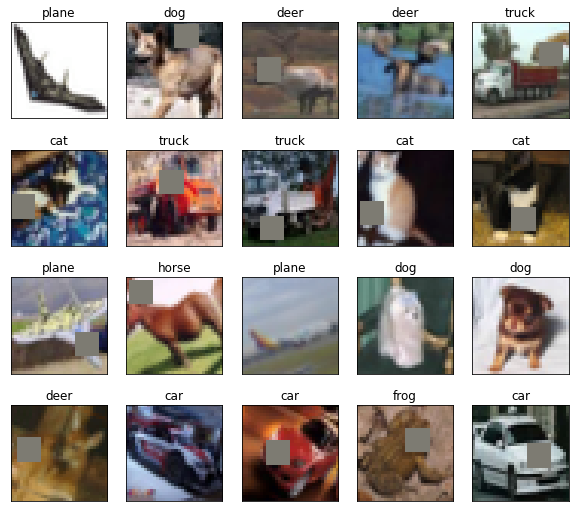

In [0]:
# visualize how image aumentation is applied on few training dataset images: 
putils.plot_dataset_images(train_loader, save_filename="albumentations_images")

# Create Resnet18 based CIFAR10 Network

In [0]:
# Create Custom Resnet - EVS session 11
model = EVAS11_ResNet()
mutils.model_summary(model, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
          MaxBlock-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
         ResBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-1, 25

In [0]:
# Create CIFAR10 network - resnet18
#model = resnet.ResNet18()
#mutils.model_summary(model, device, input_size=(3, 32, 32))

# Create CIFAR10 network using custome CNN network
#model = cifar10_net_cnn.Cifar10Net(drop_val=0.10)
#mutils.model_summary(model, device, input_size=(3, 32, 32))

# LR Range Test to find MIN and MAX LR for Training

1. update LR for each iterations and rum for many epoch
2. plot Lr vs test accuracy graph
3. get Lr value for maximum accuracy observed. this will be MAX_LR for model training
4. MIN_LR is MAX_LR/10

In [0]:
model = EVAS11_ResNet()

In [0]:
start_lr = 0.001
end_lr = 0.1  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=start_lr, momentum=0.9, nesterov=True, weight_decay=0)
lr_range_finder = LRRangeTest(model, optimizer, criterion, device=device)
lr_range_finder.range_test(train_loader, test_loader, start_lr=start_lr, end_lr=end_lr, epochs=30)

Running LR Range test
Epoch=1 Accuracy=52.04 lr=0.001 ==> 0.004299999999999988
Epoch=2 Accuracy=62.43 lr=0.004299999999999988 ==> 0.007600000000000021
Epoch=3 Accuracy=71.9 lr=0.007600000000000021 ==> 0.01090000000000001
Epoch=4 Accuracy=70.72 lr=0.01090000000000001 ==> 0.014199999999999997
Epoch=5 Accuracy=77.96 lr=0.014199999999999997 ==> 0.017499999999999988
Epoch=6 Accuracy=78.72 lr=0.017499999999999988 ==> 0.02080000000000002
Epoch=7 Accuracy=77.08 lr=0.02080000000000002 ==> 0.024100000000000007
Epoch=8 Accuracy=78.47 lr=0.024100000000000007 ==> 0.027399999999999997
Epoch=9 Accuracy=81.02 lr=0.027399999999999997 ==> 0.030699999999999984
Epoch=10 Accuracy=82.58 lr=0.030699999999999984 ==> 0.034000000000000016
Epoch=11 Accuracy=80.43 lr=0.034000000000000016 ==> 0.03730000000000001
Epoch=12 Accuracy=79.86 lr=0.03730000000000001 ==> 0.0406
Epoch=13 Accuracy=79.57 lr=0.0406 ==> 0.04390000000000003
Epoch=14 Accuracy=83.17 lr=0.04390000000000003 ==> 0.04720000000000001
Epoch=15 Accuracy=

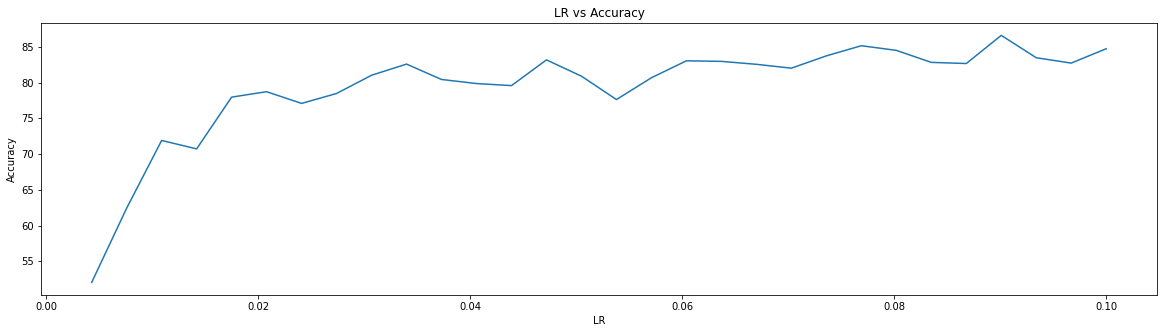

In [0]:
lr_range_finder.plot()

In [0]:
max_lr = lr_range_finder.getLrForMaxAccuracy()
min_lr = max_lr/10
print("MAX LR: ", max_lr)
print("MIN LR: ", min_lr)

MAX LR:  0.0901
MIN LR:  0.00901


# Build and train model

In [0]:
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
#from torch.optim.lr_scheduler import StepLR, MultiStepLR, OneCycleLR, LambdaLR

model_name = "CIFAR10 Resnet Custom"
model = EVAS11_ResNet()
model = model.to(device)
EPOCHS = config_params["epochs"]
L2_val = 0 # L2 Regularization not enabled.. 0.001

step_size = 5*len(train_loader)   # stepsize for LR cycle policy

step_size_up = step_size
step_size_down = EPOCHS*len(train_loader) - step_size_up # reduce LR for remaining iterations

#criterion = F.nll_loss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, nesterov=True, weight_decay=L2_val)

# CyclicLR- use one cycle policy: MAX-LR at epoch=5, Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=step_size, step_size_down=step_size_down, last_epoch=-1)

#lr_scheduler = CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=step_size, mode='triangular2')
#lr_scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=step_size, epochs=EPOCHS, last_epoch=-1)
#lr_scheduler = MultiStepLR(optimizer, milestones=[8,16,24], gamma=0.3)
#lr_scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
#lr_scheduler = LambdaLR(optimizer, one_cycle_policy1, last_epoch=-1)

# reduce LR when modle get stuck in plateu region
reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.001)

m_history = mutils.build_model_ext(model,  
                            device, 
                            trainloader=train_loader, 
                            testloader=test_loader, 
                            epochs=EPOCHS,
                            criterion=criterion, 
                            optimizer=optimizer,
                            lr_scheduler=lr_scheduler,
                            reduceLr_scheduler=reduceLr_scheduler,
                            L1_loss_enable=False)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH-1: learning rate is: 0.00901


Loss=1.348844 Batch_id=98 Accuracy=51.00 lr=0.025228000000000028: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.247212, Accuracy: 5756/10000 (57.56%)

EPOCH-2: learning rate is: 0.025228000000000028


Loss=0.851134 Batch_id=98 Accuracy=69.80 lr=0.04144599999999997: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.883553, Accuracy: 7050/10000 (70.50%)

EPOCH-3: learning rate is: 0.04144599999999997


Loss=0.643501 Batch_id=98 Accuracy=77.55 lr=0.05766399999999999: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.769162, Accuracy: 7340/10000 (73.40%)

EPOCH-4: learning rate is: 0.05766399999999999


Loss=0.545166 Batch_id=98 Accuracy=80.98 lr=0.07388200000000002: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.814394, Accuracy: 7417/10000 (74.17%)

EPOCH-5: learning rate is: 0.07388200000000002


Loss=0.476668 Batch_id=98 Accuracy=83.36 lr=0.09009999999999996: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.668698, Accuracy: 7921/10000 (79.21%)

EPOCH-6: learning rate is: 0.09009999999999996


Loss=0.380873 Batch_id=98 Accuracy=86.66 lr=0.0858321052631579: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.954317, Accuracy: 7226/10000 (72.26%)

EPOCH-7: learning rate is: 0.0858321052631579


Loss=0.298344 Batch_id=98 Accuracy=89.72 lr=0.08156421052631578: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.866300, Accuracy: 7640/10000 (76.40%)

EPOCH-8: learning rate is: 0.08156421052631578


Loss=0.248661 Batch_id=98 Accuracy=91.46 lr=0.0772963157894737: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.586105, Accuracy: 8184/10000 (81.84%)

EPOCH-9: learning rate is: 0.0772963157894737


Loss=0.199728 Batch_id=98 Accuracy=93.28 lr=0.07302842105263158: 100%|██████████| 98/98 [00:14<00:00,  6.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.658679, Accuracy: 8148/10000 (81.48%)

EPOCH-10: learning rate is: 0.07302842105263158


Loss=0.177202 Batch_id=98 Accuracy=93.99 lr=0.06876052631578947: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.595718, Accuracy: 8387/10000 (83.87%)

EPOCH-11: learning rate is: 0.06876052631578947


Loss=0.157550 Batch_id=98 Accuracy=94.70 lr=0.06449263157894737: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.461611, Accuracy: 8663/10000 (86.63%)

EPOCH-12: learning rate is: 0.06449263157894737


Loss=0.136851 Batch_id=98 Accuracy=95.43 lr=0.06022473684210526: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.540636, Accuracy: 8448/10000 (84.48%)

EPOCH-13: learning rate is: 0.06022473684210526


Loss=0.125118 Batch_id=98 Accuracy=95.83 lr=0.05595684210526318: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.502181, Accuracy: 8629/10000 (86.29%)

EPOCH-14: learning rate is: 0.05595684210526318


Loss=0.107470 Batch_id=98 Accuracy=96.51 lr=0.05168894736842104: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.511324, Accuracy: 8654/10000 (86.54%)

EPOCH-15: learning rate is: 0.05168894736842104


Loss=0.102870 Batch_id=98 Accuracy=96.58 lr=0.04742105263157895: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.514256, Accuracy: 8626/10000 (86.26%)

EPOCH-16: learning rate is: 0.04742105263157895


Loss=0.093745 Batch_id=98 Accuracy=96.97 lr=0.04315315789473685: 100%|██████████| 98/98 [00:14<00:00,  6.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.473305, Accuracy: 8762/10000 (87.62%)

EPOCH-17: learning rate is: 0.004315315789473685


Loss=0.078569 Batch_id=98 Accuracy=97.46 lr=0.03888526315789472: 100%|██████████| 98/98 [00:14<00:00,  6.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.437591, Accuracy: 8811/10000 (88.11%)

EPOCH-18: learning rate is: 0.03888526315789472


Loss=0.078730 Batch_id=98 Accuracy=97.48 lr=0.03461736842105263: 100%|██████████| 98/98 [00:14<00:00,  6.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.448911, Accuracy: 8826/10000 (88.26%)

EPOCH-19: learning rate is: 0.03461736842105263


Loss=0.073176 Batch_id=98 Accuracy=97.70 lr=0.030349473684210544: 100%|██████████| 98/98 [00:14<00:00,  6.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.428606, Accuracy: 8839/10000 (88.39%)

EPOCH-20: learning rate is: 0.030349473684210544


Loss=0.063620 Batch_id=98 Accuracy=98.01 lr=0.026081578947368407: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.450500, Accuracy: 8797/10000 (87.97%)

EPOCH-21: learning rate is: 0.026081578947368407


Loss=0.058004 Batch_id=98 Accuracy=98.22 lr=0.02181368421052632: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.424274, Accuracy: 8838/10000 (88.38%)

EPOCH-22: learning rate is: 0.02181368421052632


Loss=0.053254 Batch_id=98 Accuracy=98.21 lr=0.017545789473684226: 100%|██████████| 98/98 [00:14<00:00,  6.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.421287, Accuracy: 8892/10000 (88.92%)

EPOCH-23: learning rate is: 0.017545789473684226


Loss=0.049454 Batch_id=98 Accuracy=98.48 lr=0.013277894736842091: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.403531, Accuracy: 8913/10000 (89.13%)

EPOCH-24: learning rate is: 0.013277894736842091


Loss=0.045201 Batch_id=98 Accuracy=98.55 lr=0.00901: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]



Test set: Average loss: 0.389550, Accuracy: 8943/10000 (89.43%)



In [0]:
# Save the model for future use
filepath = "./saved_models/s11_resnet"
torch.save(model, filepath)

# Analyse the train and test best result and calculate test accuracy for each classes

In [0]:
# model result summary
m_history.result_summary()

Training best result: Accuracy: 98.55 at Epoch 24
Testing  best result: Accuracy: 89.43 at Epoch 24
Acuracy Gap: 9.12


In [0]:
# get class based test accuracy for the network
mutils.class_based_accuracy(model, device, classes, test_loader)

Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 100 %
Accuracy of  deer : 80 %
Accuracy of   dog : 100 %
Accuracy of  frog : 83 %
Accuracy of horse : 90 %
Accuracy of  ship : 62 %
Accuracy of truck : 85 %


# Visualize model history and network convergence

Visulaizing train and test result history

/content/gdrive/My Drive/TSAI/EVA_Phase1/session11/s11_submission/utils/model_history.py:110: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,x_size+1),x_size/10)
/content/gdrive/My Drive/TSAI/EVA_Phase1/session11/s11_submission/utils/model_history.py:121: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,x_size+1),x_size/10)


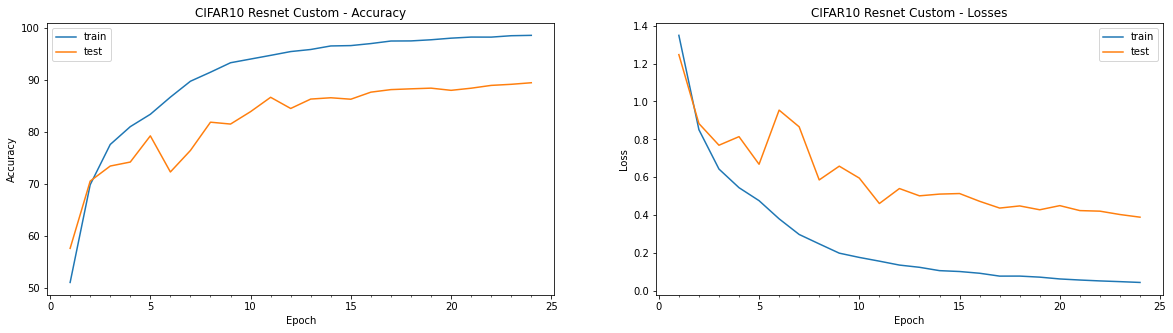

In [0]:
# Accurracy and loss history plot
m_history.plot_history(title=model_name, save_filename="model_history")

Learning rate plot

/content/gdrive/My Drive/TSAI/EVA_Phase1/session11/s11_submission/utils/model_history.py:68: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs.set_xticks(np.arange(1,x_size+1),x_size/10)


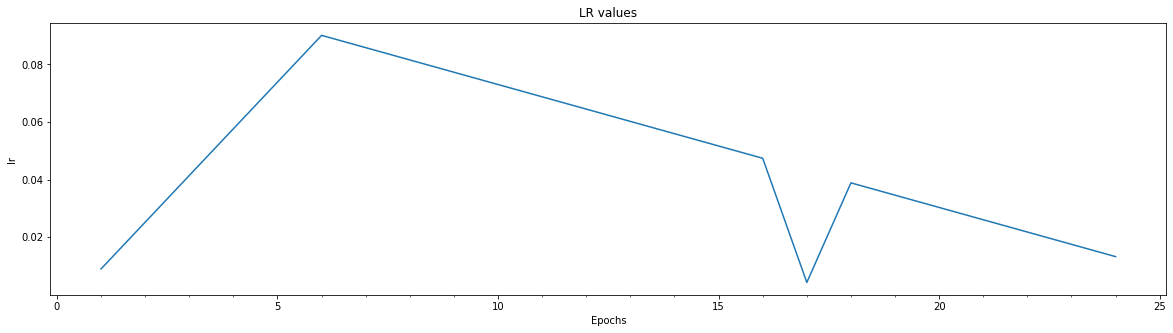

In [0]:
# Note: seriesname="val_acc", "val_loss", "train_acc", "train_loss", "lr"
m_history.plot_data_against_epoch("LR values", seriesname="lr", save_filename="lr_trend")

Visualize few misclassified images and get an understanding on for what set of unseen data model is not performing good 


Ploting misclassified images: CIFAR10 Resnet Custom



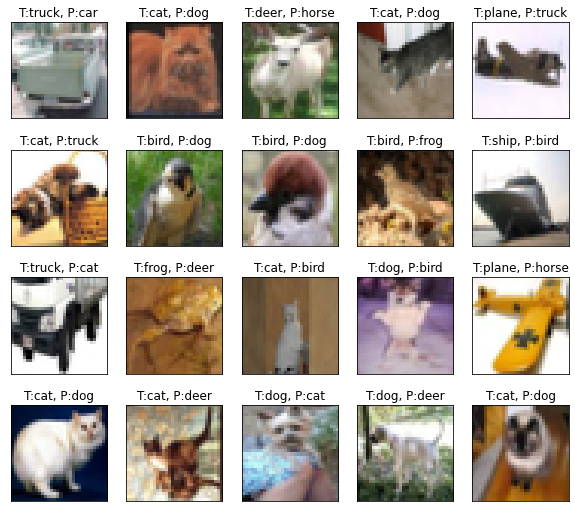

In [0]:
print("\nPloting misclassified images: {}\n".format(model_name))
putils.plot_misclassified_images(model, testloader=test_loader, save_filename="model_misclassified")

# GradCAM

In [0]:
# reload the saved model
#filepath = "./saved_models/s10_resnet18_v1"
#model = torch.load(filepath)
#model_name = "CIFAR10 Resnet18"

In [0]:
# create instance of GradCam module
config = dict(model_type='resnet', arch=model, layer_name='layer3')
gcam = gradcamAbs.GradCamAbs(device, config, means, stds)

In [0]:
# apply GradCAM on few of the test images - misclassified images
gradcam_images, pred_results = gcam.applyOnMisclassifiedImages(dataloader=test_loader, num_of_images=25)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


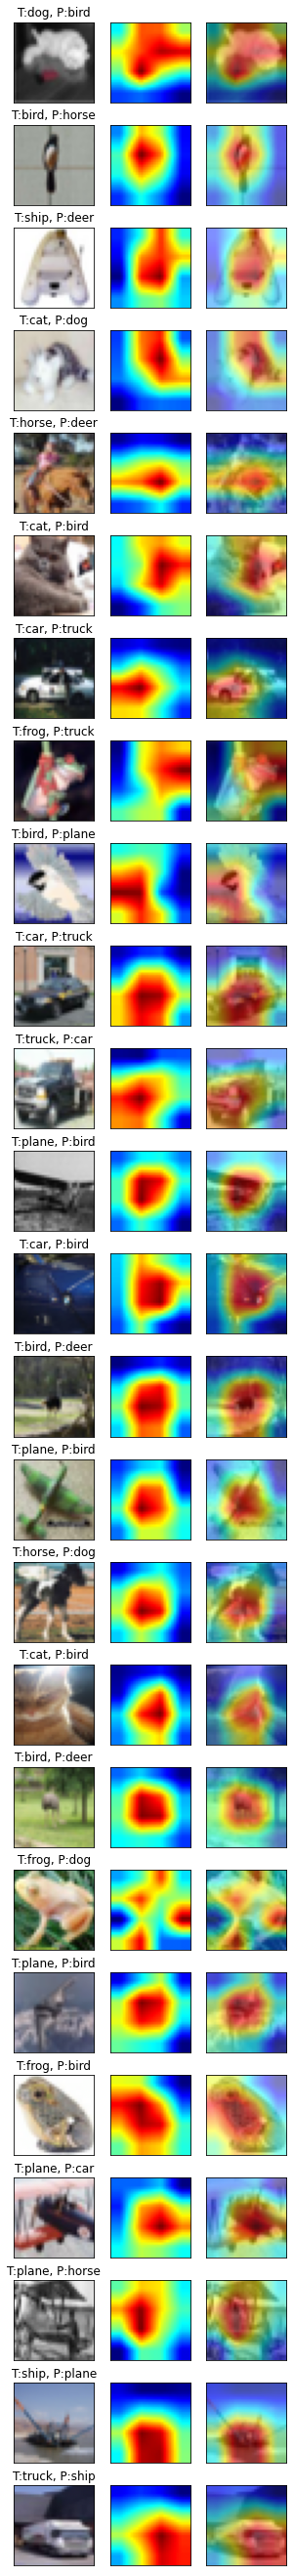

In [0]:
# misclassified images: plot the GradCAM result: original img, heatmap and super imposed image
gcam.plot_results(gradcam_images, pred_results, classes, save_filename="gradcam_result_details")

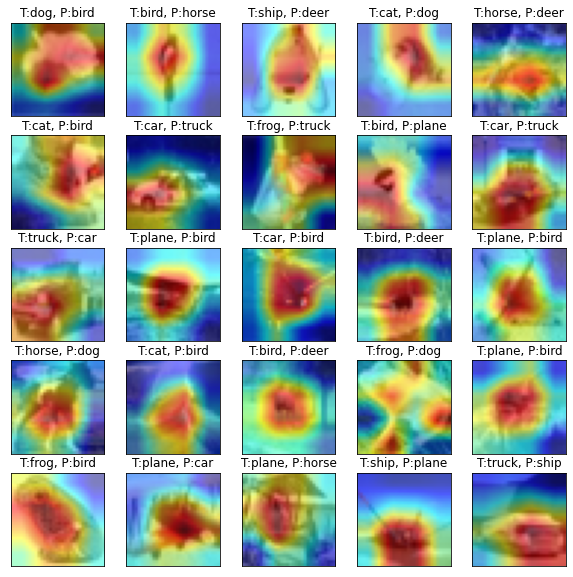

In [0]:
# misclassified images: plot the GradCAM result: only super imposed image
gcam.plot_cam_images(gradcam_images, pred_results, classes, save_filename="gradcam_superimposed_result")